In [ ]:
# data visualization
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Deep learning frame work
import tensorflow as tf

In [3]:
data = pd.read_csv("../input/sunspots/Sunspots.csv")
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
len(data)

3265

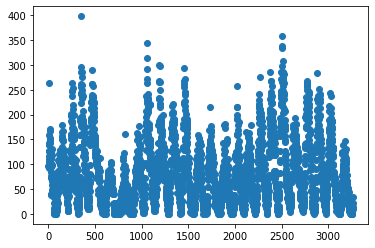

In [5]:
plt.scatter(range(len(data)),data["Monthly Mean Total Sunspot Number"])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB


In [7]:
c_data = data.copy(deep = True)

In [8]:
c_data["Date"] = pd.to_datetime(c_data["Date"])

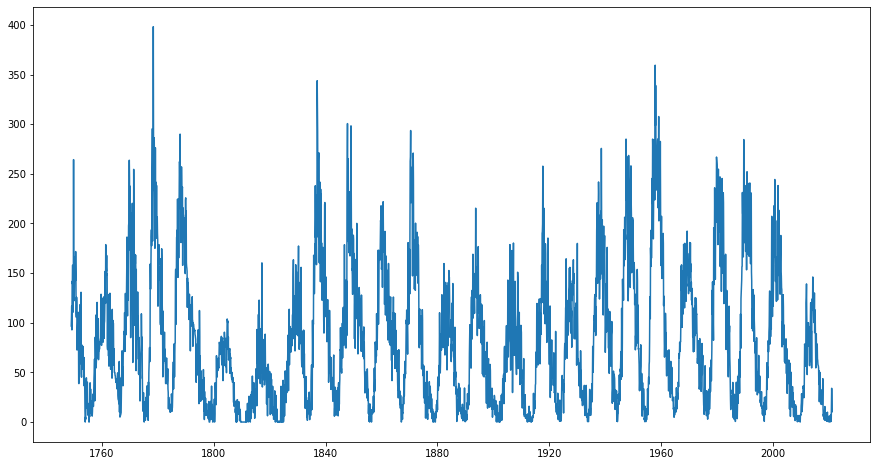

In [9]:
plt.figure(figsize=(15,8))
plt.plot(c_data["Date"],c_data["Monthly Mean Total Sunspot Number"])

In [10]:
## Range of time in this dataset
print("Range of time in this Dataset is {} to {}".format(c_data["Date"][1],c_data["Date"][len(c_data)-1]))
print("Its almost {}".format(c_data["Date"][len(c_data)-1]-c_data["Date"][1]))

Range of time in this Dataset is 1749-02-28 00:00:00 to 2021-01-31 00:00:00
Its almost 99318 days 00:00:00


In [11]:
series = np.array(data.iloc[:,2])
time_step = np.array(data.iloc[:,1])

In [12]:
### splitting data into time and test series.
split_time = 2000
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 2000

## Preparing the windowed dataset for our model

In [14]:
def windowed_dataset(series,batch_size,window,shuffle_buffer_size):
    series = tf.expand_dims(series,axis = -1) ## making 2-dimensional array
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift =1 , drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Model Training

In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_mae')<15):
            print("MAE Achieved !!!")
            self.model.stop_training = True
        
window_size = 60
batch_size = 320
train_set = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
val_set = windowed_dataset(x_valid,window_size,batch_size,shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120,input_shape = (window_size,), return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.SimpleRNN(60,return_sequences = True),
    tf.keras.layers.SimpleRNN(30,return_sequences  = True),
    tf.keras.layers.Dense(30,activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(10,activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(1),
    #tf.keras.layers.Lambda(lambda x:x*400)
])

callbacks = mycallback()
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8*10**(epoch/20))
optimizers = tf.keras.optimizers.SGD(lr = 1e-5,momentum = 0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 2)
model.compile(loss = tf.keras.losses.Huber(),optimizer=optimizers,metrics = ['mae'])
history = model.fit(train_set,epochs = 250,validation_data= val_set)

Epoch 1/250
33/33 [==============================] - 17s 231ms/step - loss: 75.2512 - mae: 75.7388 - val_loss: 91.0214 - val_mae: 91.5168
Epoch 2/250
33/33 [==============================] - 6s 183ms/step - loss: 74.4817 - mae: 74.9711 - val_loss: 90.6378 - val_mae: 91.1337
Epoch 3/250
33/33 [==============================] - 6s 184ms/step - loss: 75.1333 - mae: 75.6255 - val_loss: 90.2802 - val_mae: 90.7767
Epoch 4/250
33/33 [==============================] - 7s 193ms/step - loss: 73.2745 - mae: 73.7676 - val_loss: 89.9715 - val_mae: 90.4683
Epoch 5/250
33/33 [==============================] - 7s 189ms/step - loss: 72.6276 - mae: 73.1216 - val_loss: 89.7199 - val_mae: 90.2170
Epoch 6/250
33/33 [==============================] - 6s 179ms/step - loss: 72.5936 - mae: 73.0877 - val_loss: 89.4829 - val_mae: 89.9797
Epoch 7/250
33/33 [==============================] - 6s 176ms/step - loss: 74.6134 - mae: 75.1087 - val_loss: 89.2449 - val_mae: 89.7415
Epoch 8/250
33/33 [=====================

## Model Summary

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 240)         117120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 120)         144480    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 60)          10860     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 30)          2730      
_________________________________________________________________
dense (Dense)                (None, None, 30)          930       
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           1

## Getting the forecasts

In [66]:
rnn_forecast = model_forecast(model,series[...,np.newaxis],window_size)
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

In [22]:
rnn_forecast

array([103.5601   ,  93.675644 ,  85.28905  , ...,   2.0012028,
        14.161951 ,  20.72472  ], dtype=float32)

## Plotting original vs Forecasted

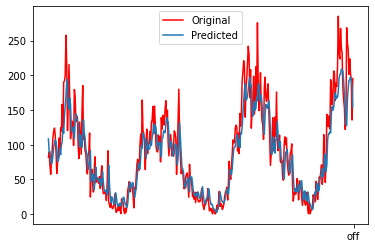

In [67]:
plt.plot(time_valid[:400],x_valid[:400],"r",label = "Original")
plt.plot(time_valid[:400],rnn_forecast[:400],label = "Predicted")
plt.xticks("off")
plt.legend(loc='best')

## Predicting the next value as our model contains value till 3265, So for window size = 60, we take the the series for predition as 3205:3265

In [88]:
model.predict(tf.expand_dims(tf.expand_dims(series[3205:3265],0),1))

array([[[8.041251]]], dtype=float32)

<Figure size 432x288 with 0 Axes>

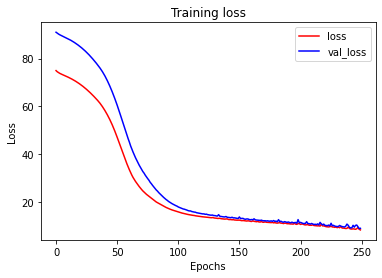

<Figure size 432x288 with 0 Axes>

In [89]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
val_loss = history.history['val_loss']


epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label = 'loss')
plt.plot(epochs,val_loss,"b",label = 'val_loss')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc= 'best')

plt.figure()